# Exemplo 11: Aprendizagem de Máquina Serial
## Identificação espécie de flores com Iris Dataset
---

Machine learning is the method of extracting knowledge from data. It is a field at the intersection of statistics, artificial intelligence, and computer science and is also used to predict analytics or statistic learning. They are called supervised learning algorithms because it is necessary to provide supervision to the algorithms in the form of the desired outputs for each example that they learn from. So, each line of dataset has the correct answer for the problem, in this casa, a correct classification. The Iris specie identification is a basic example of machine learning pratice. It is the "Hello world" in machine learning.

The Iris problem is so well understood and has intersting characteristics: (1) Attributes are numeric so you have to figure out how to load and handle data; (2) It is a classification problem, allowing you to practice with perhaps an easier type of supervised learning algorithm; (3) It is a multi-class classification problem (multi-nominal) that may require some specialized handling; (4) It only has 4 attributes and 150 rows, meaning it is small and easily fits into memory (and a screen or A4 page); and, (5) All of the numeric attributes are in the same units and the same scale, not requiring any special scaling or transforms to get started.

## Iris Plants Database
----

This is perhaps the best known database to be found in the pattern recognition literature. Fisher's paper is a classic in the field and is referenced frequently to this day. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  One class is linearly separable from the other 2; the latter are NOT linearly separable from each other.

### Predicted attribute:
Class of iris plant.

### Number of Instances:
150 (50 in each of three classes)

### Number of Attributes:
4 numeric, predictive attributes and the class

### Attribute Information:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class: 
 + Iris Setosa
  + Iris Versicolour
   + Iris Virginica

### Missing Attribute Values: 
None

### Class Distribution: 
33.3% for each of 3 classes.

## Summary Statistics
-----

Attributes | Min | Max | Mean | SD | Class Correlation
-----------|-----|-----|------|----|------------
sepal length | 4.3 | 7.9 | 5.84 | 0.83 | 0.7826   
sepal width | 2.0 | 4.4 | 3.05 | 0.43 | -0.4194
petal length | 1.0 | 6.9 | 3.76 | 1.76 | 0.9490  
petal width | 0.1 | 2.5 | 1.20 | 0.76 | 0.9565 

## References:

1. Fisher,R.A. "The use of multiple measurements in taxonomic problems" Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions to Mathematical Statistics" (John Wiley, NY, 1950).
      
2. Duda,R.O., & Hart,P.E. (1973) Pattern Classification and Scene Analysis. John Wiley & Sons. ISBN 0-471-22361-1. 

In [1]:
# Load libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils

## SKLearn Lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

import time
start_time = time.time()
%matplotlib inline

## Configure parameters

In [2]:
# Path to dataset file
data_path='./data/'

# Sample of train and test dataset
train_sample = 0.7
test_sample = 0.3

## Read and show dataset

In [3]:
# Importing the dataset
dataset = pd.read_csv(data_path+"iris.data")

# Print dataset
dataset.head(5)

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
print("Number of itens per class")
dataset.groupby('class').size()

Number of itens per class


class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

In [5]:
# Read features and calass
feature_columns = ['sepal length', 'sepal width', 'petal length','petal width']
X = dataset[feature_columns].values
y = dataset['class'].values

# SKLearn need all column as numbers. Tranform "class" column in number
le = LabelEncoder()
y = le.fit_transform(y)

# Split ramdomly the dataset into train and test group
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_sample, random_state = 0)

<Figure size 640x480 with 0 Axes>

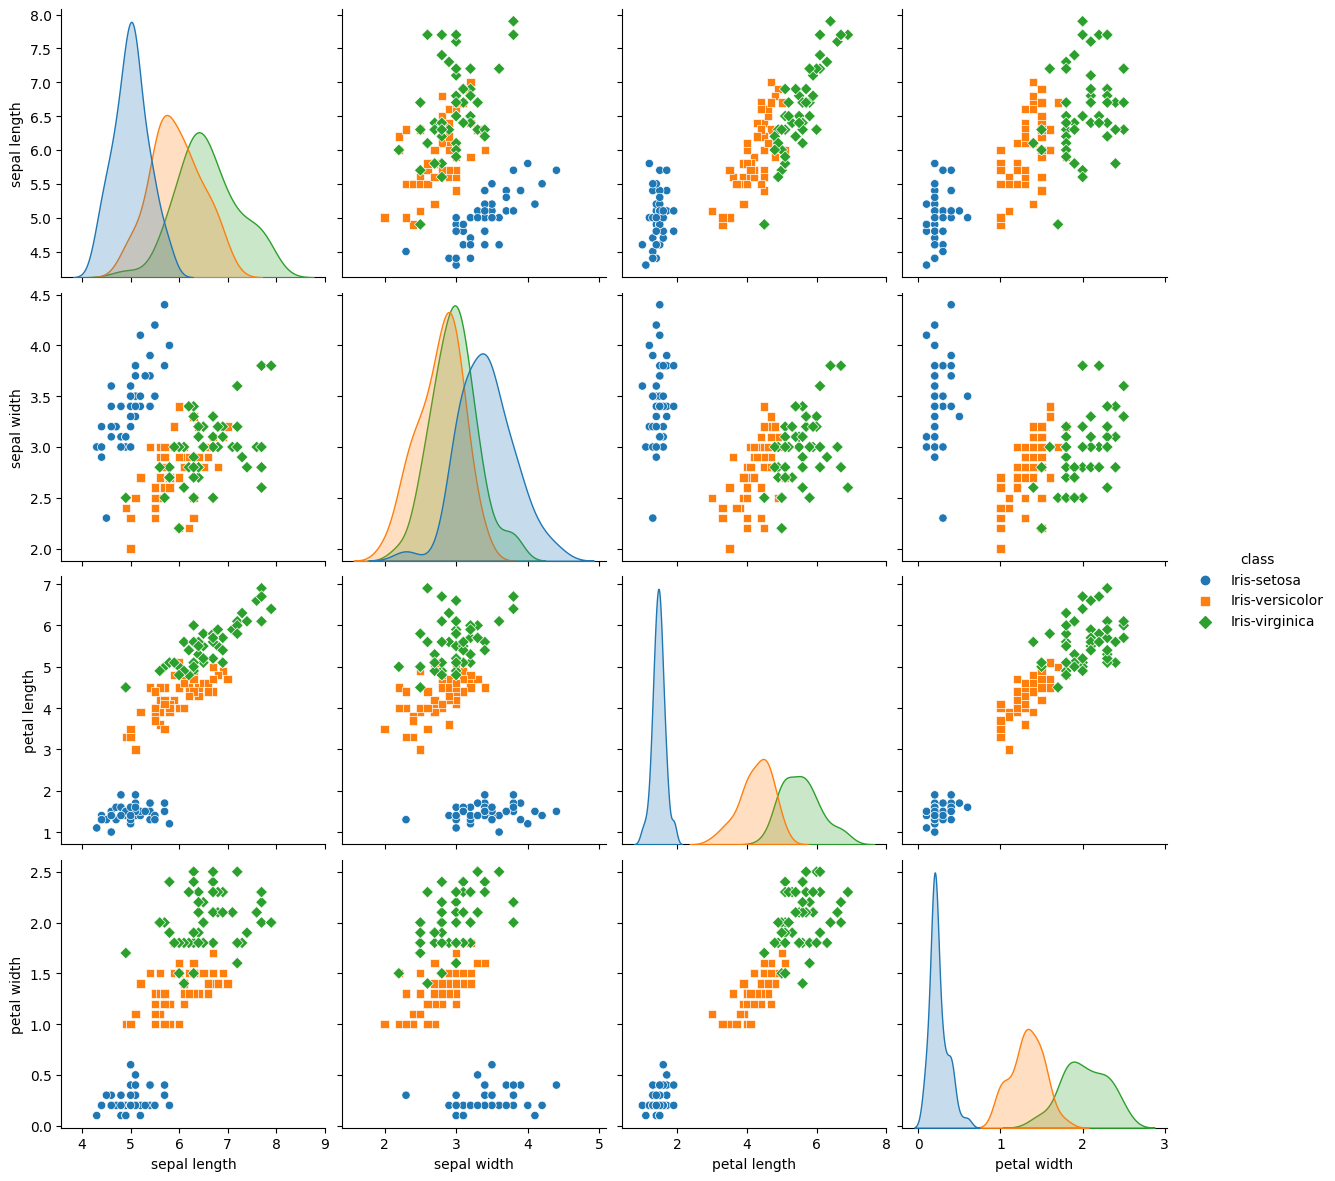

In [6]:
plt.figure()
sns.pairplot(dataset, hue = "class", height=3, markers=["o", "s", "D"])
plt.show()

## KNN using Scikit-learn

In [7]:
start_time_knn =  time.time()
# Instantiate learning model (k = 3)
classifier = KNeighborsClassifier(n_neighbors=3)

# Fitting the model
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [8]:
accuracy_knn = accuracy_score(y_test, y_pred)*100
time_knn = time.time() - start_time_knn
print('KNN accuracy = ' + str(round(accuracy_knn, 1)) + ' %.')
print("K-Nearest Neighbors (KNN): accuracy = %3.1f %%" % accuracy_knn)
print("K-Nearest Neighbors (KNN): time = %3.3f s" % time_knn)

KNN accuracy = 97.8 %.
K-Nearest Neighbors (KNN): accuracy = 97.8 %
K-Nearest Neighbors (KNN): time = 0.240 s


## Create Spark environment

In [9]:
# Create Spark Session
sc = SparkSession.builder \
     .master("local[*]") \
     .appName("MachineLearningIris") \
     .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/17 09:07:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Reading Data

In [10]:
# Load Iris CSV dataset to Spark Dataframe
orig_data = sc.read.format("csv").options(sep=',',header='true',inferschema='true').\
            load(data_path+"iris.data")

print("Original Dataframe read from CSV file")
#orig_data.dtypes
orig_data.show(5)

Original Dataframe read from CSV file
+------------+-----------+------------+-----------+-----------+
|sepal length|sepal width|petal length|petal width|      class|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



### Create Classifier Matrix

In [11]:
# ML libraries doesn't accept string column => everything should be numeric! 
# create a numeric column "label" based on string column "class" 

indexer = StringIndexer(inputCol="class", outputCol="label").fit(orig_data)
label_data = indexer.transform(orig_data)

# Save the inverse map from numeric "label" to string "class" to be used further in response
labelReverse = IndexToString().setInputCol("label")

# Show labeled dataframe with numeric lable
print("Dataframe with numeric lable")
label_data.show(5)

Dataframe with numeric lable
+------------+-----------+------------+-----------+-----------+-----+
|sepal length|sepal width|petal length|petal width|      class|label|
+------------+-----------+------------+-----------+-----------+-----+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|  0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|  0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|  0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|  0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|  0.0|
+------------+-----------+------------+-----------+-----------+-----+
only showing top 5 rows



In [12]:
# Drop string column "class", no string column
label_data = label_data.drop("class")

# Most Machine Learning Lib inpute 2 columns: label (output) and feature (input)
# The label column is the result to train ML algorithm 
# The feature column should join all parameters as a Vector

# Set the column names that is not part of features list
ignore = ['label']
# list will be all columns parts of features
list = [x for x in label_data.columns if x not in ignore]

# VectorAssembler mount the vector of features
assembler = VectorAssembler(
            inputCols=list,
            outputCol='features')

# Create final dataframe composed by label and a column of features vector
data = (assembler.transform(label_data).select("label","features"))

print("Final Dataframe suitable to classifier input format")
#data.printSchema()
data.show(5)

Final Dataframe suitable to classifier input format
+-----+-----------------+
|label|         features|
+-----+-----------------+
|  0.0|[5.1,3.5,1.4,0.2]|
|  0.0|[4.9,3.0,1.4,0.2]|
|  0.0|[4.7,3.2,1.3,0.2]|
|  0.0|[4.6,3.1,1.5,0.2]|
|  0.0|[5.0,3.6,1.4,0.2]|
+-----+-----------------+
only showing top 5 rows



### Create Train and Test Dataset

In [13]:
# Split ramdomly the dataset into train and test group
# [0.7,0.3] => 70% for train and 30% for test
# [1.0,0.2] => 100% for train and 20% for test, not good, acuracy always 100%
# [0.1,0.02] => 10% for train and 2% for test, if big datasets
# 1234 is the random seed

(train, test) = data.randomSplit([train_sample, test_sample], 1234)

## Run Decision Tree

In [14]:
start_time_dt =  time.time()

# impurity could be: entropy, gini'

trainer = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', seed=None)

#trainer = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# train the model and get the result
model = trainer.fit(train)
result_dt = model.transform(test)

In [15]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_dt = evaluator.evaluate(result_dt) * 100
time_dt = time.time() - start_time_dt

print("Decision Tree: accuracy = %3.1f %%" % accuracy_dt)
print("Decision Tree: time = %3.3f s" % time_dt)

Decision Tree: accuracy = 96.1 %
Decision Tree: time = 2.066 s


In [16]:
print("Decision Tree Final Result")
result_dt.show(5)

Decision Tree Final Result
+-----+-----------------+--------------+-------------+----------+
|label|         features| rawPrediction|  probability|prediction|
+-----+-----------------+--------------+-------------+----------+
|  0.0|[4.3,3.0,1.1,0.1]|[36.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|  0.0|[4.4,2.9,1.4,0.2]|[36.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|  0.0|[4.5,2.3,1.3,0.3]|[36.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|  0.0|[5.0,3.2,1.2,0.2]|[36.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|  0.0|[5.0,3.4,1.6,0.4]|[36.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
+-----+-----------------+--------------+-------------+----------+
only showing top 5 rows



## Run Random Forest

In [17]:
start_time_rf =  time.time()

trainer = RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 numTrees=50, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini')

# impurity could be: entropy, gini'
# numTrees= set the number of random trees to create

# train the model and get the result
model = trainer.fit(train)
result_rf = model.transform(test)

In [18]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_rf = evaluator.evaluate(result_rf) * 100
time_rf = time.time() - start_time_rf

print("Random Forest: accuracy = %3.1f %%" % accuracy_rf)
print("Random Forest: time = %3.3f s" % time_rf)

Random Forest: accuracy = 96.1 %
Random Forest: time = 1.455 s


In [19]:
print("Decision Tree Final Result")
result_rf.show(5)

Decision Tree Final Result
+-----+-----------------+--------------+---------------+----------+
|label|         features| rawPrediction|    probability|prediction|
+-----+-----------------+--------------+---------------+----------+
|  0.0|[4.3,3.0,1.1,0.1]|[50.0,0.0,0.0]|  [1.0,0.0,0.0]|       0.0|
|  0.0|[4.4,2.9,1.4,0.2]|[50.0,0.0,0.0]|  [1.0,0.0,0.0]|       0.0|
|  0.0|[4.5,2.3,1.3,0.3]|[49.0,1.0,0.0]|[0.98,0.02,0.0]|       0.0|
|  0.0|[5.0,3.2,1.2,0.2]|[50.0,0.0,0.0]|  [1.0,0.0,0.0]|       0.0|
|  0.0|[5.0,3.4,1.6,0.4]|[50.0,0.0,0.0]|  [1.0,0.0,0.0]|       0.0|
+-----+-----------------+--------------+---------------+----------+
only showing top 5 rows



## Run Neural network Perceptron

In [20]:
start_time_pr =  time.time()

# specify layers for the neural network
# parameter 1: input layer, should be the number of features
# parameter 2 and 3: the number os perceptron in two hidden layers
# parameter 4: output layer should be the number os categories (labels)
# More hidden layers will make the neural network more complex but do not ensure more accuracy.
layers = [4, 5, 5, 3]

# Create the trainer and set its parameters:
# featuresCol: name of feature_column
# labelCol: name of label column
# maxIter: number max interaction
# layers: number of input, output and hidden layer (see above)
# tol: convergence tolerance towards the outputs and the correct results. The default value is 1e-06.
#      Smaller values yield more accurate results while large values might lead to overfitting.
# seed: the random seed value using to random numbers generator. 
# blockSize: number of inputs to be included during each iteration of the algorithm.
#       Default value is 128. Smaller blockSize improves accuracy at the expense of
#       prolonged learning time and vice versa.
# stepSize: learning rate of the algorithm, usually between 0.0 to 1.0. It is how quickly or slowly the model
#       learns. The default is 0.03. A smaller value can lead to improved accuracy while larger values can
#       lead to over-fitting.
# solver: specifies which optimization algorithm should be used to find the local minimum.
#       'gd' is gradient descent and 'l-bfgs' is Limited-memory BFGS (default).

trainer = MultilayerPerceptronClassifier(featuresCol='features', labelCol='label',\
          maxIter=100, tol=1e-07, layers=layers, seed=1234, blockSize=64, stepSize=0.02, solver='l-bfgs')

# train the model and get the result
model = trainer.fit(train)
result_pr = model.transform(test)

print("Perceptron Final Result")
result_pr.show(5)

24/01/17 09:07:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Perceptron Final Result
+-----+-----------------+--------------------+--------------------+----------+
|label|         features|       rawPrediction|         probability|prediction|
+-----+-----------------+--------------------+--------------------+----------+
|  0.0|[4.3,3.0,1.1,0.1]|[40.5370765776091...|[1.0,4.4822005194...|       0.0|
|  0.0|[4.4,2.9,1.4,0.2]|[40.5370765776091...|[1.0,4.4822005194...|       0.0|
|  0.0|[4.5,2.3,1.3,0.3]|[40.5370765776091...|[1.0,4.4822005194...|       0.0|
|  0.0|[5.0,3.2,1.2,0.2]|[40.5370765776091...|[1.0,4.4822005194...|       0.0|
|  0.0|[5.0,3.4,1.6,0.4]|[40.5370765776091...|[1.0,4.4822005194...|       0.0|
+-----+-----------------+--------------------+--------------------+----------+
only showing top 5 rows



In [21]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_pr = evaluator.evaluate(result_pr) * 100
time_pr = time.time() - start_time_pr

print("Multilayer Perceptron: accuracy = %3.1f %%" % accuracy_pr)
print("Multilayer Perceptron: time = %3.3f s" % time_pr)

Multilayer Perceptron: accuracy = 98.0 %
Multilayer Perceptron: time = 6.099 s


In [22]:
print("Perceptron final result with name of class")
labelReverse.transform(result_pr).show()

Perceptron final result with name of class
+-----+-----------------+--------------------+--------------------+----------+----------------------------------+
|label|         features|       rawPrediction|         probability|prediction|IndexToString_2994a21b1238__output|
+-----+-----------------+--------------------+--------------------+----------+----------------------------------+
|  0.0|[4.3,3.0,1.1,0.1]|[40.5370765776091...|[1.0,4.4822005194...|       0.0|                       Iris-setosa|
|  0.0|[4.4,2.9,1.4,0.2]|[40.5370765776091...|[1.0,4.4822005194...|       0.0|                       Iris-setosa|
|  0.0|[4.5,2.3,1.3,0.3]|[40.5370765776091...|[1.0,4.4822005194...|       0.0|                       Iris-setosa|
|  0.0|[5.0,3.2,1.2,0.2]|[40.5370765776091...|[1.0,4.4822005194...|       0.0|                       Iris-setosa|
|  0.0|[5.0,3.4,1.6,0.4]|[40.5370765776091...|[1.0,4.4822005194...|       0.0|                       Iris-setosa|
|  0.0|[5.0,3.5,1.3,0.3]|[40.5370765776091...

## Run Naive Bayes

In [23]:
start_time_nb =  time.time()
# create the trainer and set its parameters
trainer = NaiveBayes(smoothing=1.0, modelType="multinomial")

#trainer = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
#trainer = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# train the model and get the result
model = trainer.fit(train)
result_nb = model.transform(test)

In [24]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_nb = evaluator.evaluate(result_nb) * 100
time_nb = time.time() - start_time_nb

print("Naive Bayes: accuracy = %3.1f %%" % accuracy_nb)
print("Naive Bayes: time = %3.3f s" % time_nb)

Naive Bayes: accuracy = 94.1 %
Naive Bayes: time = 0.705 s


In [25]:
print("Naive Bayes Final Result")
result_nb.show()

Naive Bayes Final Result
+-----+-----------------+--------------------+--------------------+----------+
|label|         features|       rawPrediction|         probability|prediction|
+-----+-----------------+--------------------+--------------------+----------+
|  0.0|[4.3,3.0,1.1,0.1]|[-9.8142255743237...|[0.76047282856028...|       0.0|
|  0.0|[4.4,2.9,1.4,0.2]|[-10.720518117014...|[0.67984894537352...|       0.0|
|  0.0|[4.5,2.3,1.3,0.3]|[-10.317922017210...|[0.58699908426157...|       0.0|
|  0.0|[5.0,3.2,1.2,0.2]|[-11.090970249080...|[0.76857379655712...|       0.0|
|  0.0|[5.0,3.4,1.6,0.4]|[-12.811371398865...|[0.67694971737530...|       0.0|
|  0.0|[5.0,3.5,1.3,0.3]|[-11.976466752683...|[0.76166264726324...|       0.0|
|  0.0|[5.0,3.5,1.6,0.6]|[-13.656752323798...|[0.62634338059920...|       0.0|
|  0.0|[5.0,3.6,1.4,0.2]|[-11.908115226943...|[0.78367311733531...|       0.0|
|  0.0|[5.1,3.4,1.5,0.2]|[-11.954207194741...|[0.75324027253744...|       0.0|
|  0.0|[5.1,3.5,1.4,0.3]|[-

In [26]:
print("Naive Bayes final result with name of class")
labelReverse.transform(result_nb).show()

Naive Bayes final result with name of class
+-----+-----------------+--------------------+--------------------+----------+----------------------------------+
|label|         features|       rawPrediction|         probability|prediction|IndexToString_2994a21b1238__output|
+-----+-----------------+--------------------+--------------------+----------+----------------------------------+
|  0.0|[4.3,3.0,1.1,0.1]|[-9.8142255743237...|[0.76047282856028...|       0.0|                       Iris-setosa|
|  0.0|[4.4,2.9,1.4,0.2]|[-10.720518117014...|[0.67984894537352...|       0.0|                       Iris-setosa|
|  0.0|[4.5,2.3,1.3,0.3]|[-10.317922017210...|[0.58699908426157...|       0.0|                       Iris-setosa|
|  0.0|[5.0,3.2,1.2,0.2]|[-11.090970249080...|[0.76857379655712...|       0.0|                       Iris-setosa|
|  0.0|[5.0,3.4,1.6,0.4]|[-12.811371398865...|[0.67694971737530...|       0.0|                       Iris-setosa|
|  0.0|[5.0,3.5,1.3,0.3]|[-11.976466752683..

## Run Suport Vector Machines (SVM)

In [27]:
start_time_svm =  time.time()

# create the trainer and set its parameters
trainer = LinearSVC(featuresCol='features', labelCol='label',\
                    maxIter=100, regParam=0.1)

# LinearSVC classify ONLY in two classes
# To classify in more than 2 classes, the OneVsrest should be used
# Cloud use any kind of classifies

# instantiate the One Vs Rest Classifier.
ovr_trainer = OneVsRest(classifier=trainer)

# train the multiclass model.
model = ovr_trainer.fit(train)

# score the model on test data.
result_svm = model.transform(test)

In [28]:
# compute accuracy on the test set against model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",\
            metricName="accuracy")

accuracy_svm = evaluator.evaluate(result_svm) * 100
time_svm = time.time() - start_time_svm

print("Suport Vector Machines (SVM): accuracy = %3.1f %%" % accuracy_svm)
print("Suport Vector Machines (SVM): time = %3.3f s" % time_svm)

Suport Vector Machines (SVM): accuracy = 88.2 %
Suport Vector Machines (SVM): time = 70.195 s


In [29]:
print("Suport Vector Machines (SVM) Final Result")
result_svm.show()

Suport Vector Machines (SVM) Final Result
+-----+-----------------+--------------------+----------+
|label|         features|       rawPrediction|prediction|
+-----+-----------------+--------------------+----------+
|  0.0|[4.3,3.0,1.1,0.1]|[1.31296141384472...|       0.0|
|  0.0|[4.4,2.9,1.4,0.2]|[1.02993901650780...|       0.0|
|  0.0|[4.5,2.3,1.3,0.3]|[0.43199998676442...|       0.0|
|  0.0|[5.0,3.2,1.2,0.2]|[1.17831687833307...|       0.0|
|  0.0|[5.0,3.4,1.6,0.4]|[1.08803761248537...|       0.0|
|  0.0|[5.0,3.5,1.3,0.3]|[1.34116409001276...|       0.0|
|  0.0|[5.0,3.5,1.6,0.6]|[1.03572294832986...|       0.0|
|  0.0|[5.0,3.6,1.4,0.2]|[1.46810565732330...|       0.0|
|  0.0|[5.1,3.4,1.5,0.2]|[1.23022289291024...|       0.0|
|  0.0|[5.1,3.5,1.4,0.3]|[1.27972194264903...|       0.0|
|  0.0|[5.1,3.7,1.5,0.4]|[1.35434884580405...|       0.0|
|  0.0|[5.2,3.4,1.4,0.2]|[1.23187320065493...|       0.0|
|  0.0|[5.5,3.5,1.3,0.2]|[1.26195197730523...|       0.0|
|  0.0|[5.7,3.8,1.7,0.3]|[1.27

## Sumary

In [30]:
print("==================================================================")
print("=============  Compare Algorithm Acurancy and Time ===============")
print()
print("      Train sample = ",train_sample*100,"%     Test sample = ",test_sample*100,"%")
print()
print("K-Nearest Neighbors (KNN):    accuracy = %3.1f %%   time = %3.3f s" % (accuracy_knn, time_knn))
print("Decision Tree:                accuracy = %3.1f %%   time = %3.3f s" % (accuracy_dt, time_dt))
print("Random Forest:                accuracy = %3.1f %%   time = %3.3f s" % (accuracy_rf, time_rf))
print("Multilayer Perceptron:        accuracy = %3.1f %%   time = %3.3f s" % (accuracy_pr, time_pr))
print("Naive Bayes:                  accuracy = %3.1f %%   time = %3.3f s" % (accuracy_nb, time_nb))
print("Suport Vector Machines (SVM): accuracy = %3.1f %%   time = %3.3f s" % (accuracy_svm, time_svm))
print("===================================================================")

=============  Compare Algorithm Acurancy and Time ===============

      Train sample =  70.0 %     Test sample =  30.0 %

K-Nearest Neighbors (KNN):    accuracy = 97.8 %   time = 0.240 s
Decision Tree:                accuracy = 96.1 %   time = 2.066 s
Random Forest:                accuracy = 96.1 %   time = 1.455 s
Multilayer Perceptron:        accuracy = 98.0 %   time = 6.099 s
Naive Bayes:                  accuracy = 94.1 %   time = 0.705 s
Suport Vector Machines (SVM): accuracy = 88.2 %   time = 70.195 s


In [31]:
sc.stop()
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 97.62607312202454 seconds ---
